In [1]:
import json
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from natsort import natsorted
import os

Total number of json files:  10
Processing file:  nusmv.syncarb5^2.B_0.json


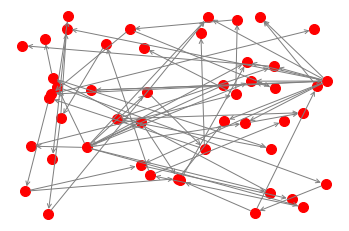

Processing file:  nusmv.syncarb5^2.B_4.json


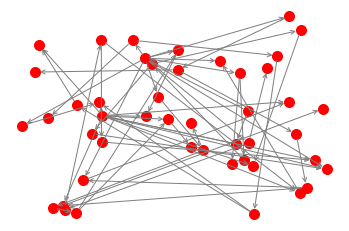

Processing file:  nusmv.syncarb5^2.B_5.json


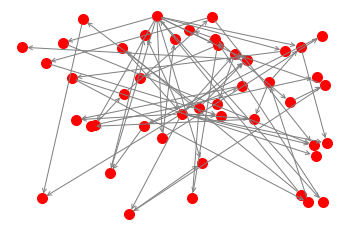

Processing file:  nusmv.syncarb5^2.B_9.json


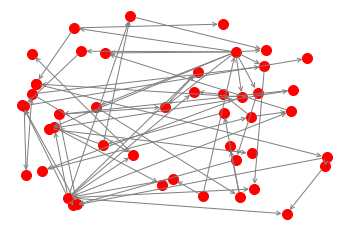

Processing file:  nusmv.syncarb5^2.B_1.json


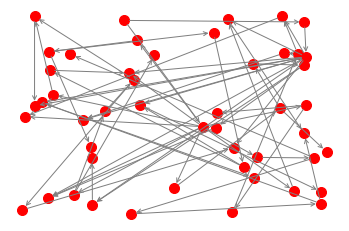

Processing file:  nusmv.syncarb5^2.B_8.json


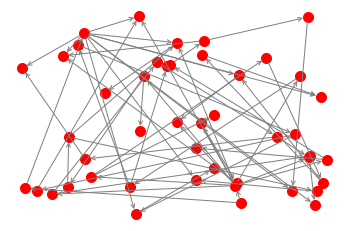

Processing file:  nusmv.syncarb5^2.B_2.json


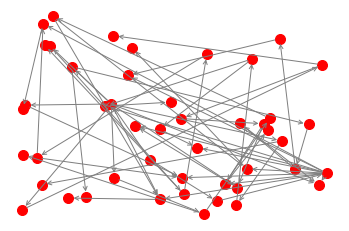

Processing file:  nusmv.syncarb5^2.B_7.json


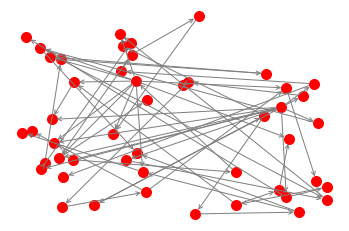

Processing file:  nusmv.syncarb5^2.B_3.json


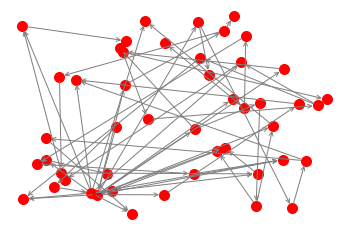

Processing file:  nusmv.syncarb5^2.B_6.json


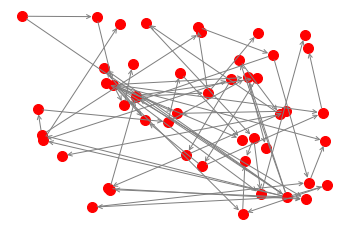

In [2]:
def json2graph_pickle(filename,ground_truth_path):
    with open(filename) as f:
        json_data = json.loads(f.read())

    # rank json_data by 'type' and 'id', node - input_var - variable -> sequence like this
    json_data = sorted(json_data, key=lambda x: (x['data']['type'], x['data']['application']))

    #G = nx.DiGraph()
    G = nx.MultiDiGraph()

    G.add_nodes_from(
        elem['data']['id']
        for elem in json_data
    )

    edge_list = []

    for elem in json_data: 
        if elem['data']['type']=='node':
            edge_list.extend((child_id,elem['data']['id']) for child_id in elem['data']['to']['children_id'])

    G.add_edges_from(
        edge_list
    )

    # Print the graph by networkx api
    # nx.draw(
    #     G,
    #     with_labels=True
    # )

    # Print the graph by matplotlib
    pos = nx.random_layout(G)
    nx.draw_networkx_nodes(G, pos, node_color = 'r', node_size = 100, alpha = 1)
    ax = plt.gca()
    for e in G.edges:
        ax.annotate("",
                    xy=pos[e[0]], xycoords='data',
                    xytext=pos[e[1]], textcoords='data',
                    arrowprops=dict(arrowstyle="->", color="0.5",
                                    shrinkA=5, shrinkB=5,
                                    patchA=None, patchB=None,
                                    connectionstyle="arc3,rad=rrr".replace('rrr',str(0.3*e[2])
                                    ),
                                    ),
                    )
    plt.axis('off')
    plt.show()

    # Convert graph to numpy matrix
    A=np.array(nx.to_numpy_matrix(G))

    # Get G egdes to dataframe
    edge_df = nx.to_pandas_adjacency(G, dtype=int) # The ordering is produced by G.nodes()

    #Adjust the order of dataframe is possible: read nodes by our preferred order 

    #dump G and json_data to pickle

    #define the pickle file name
    pickle_file_name = '../../dataset/bad_cube_cex2graph/json_to_graph_pickle/' + filename.split('/')[-1].replace('.json', '.pkl')

    # get ground truth list from '../../dataset/IG2graph/generalization_no_enumerate/' + filename.split('/')[-1].replace('.json', '.csv')
    case_name = ground_truth_path.split('/')[-1]
    ground_truth_table = pd.read_csv(f'{ground_truth_path}/{case_name}.csv')

    # only keep the particular case
    ground_truth_table = ground_truth_table[ground_truth_table['inductive_check']==filename.split('/')[-1].replace('.json', '.smt2')]
    label = ground_truth_table

    #ground_truth_table.drop("Unnamed: 0", axis=1, inplace=True)
    #ground_truth_table = ground_truth_table.reindex(natsorted(ground_truth_table.columns), axis=1)
    #label = (ground_truth_table.values.tolist())[:] 

    # get the exact label of the graph by the name of the graph
    # lambda_get_index = lambda x: x[0]==filename.split('/')[-1].replace('.json', '.smt2')
    # for i in range(len(label)):
    #     if lambda_get_index(label[i]):
    #         label = label[i]
    #         break

    with open(pickle_file_name, 'wb') as f:
        pickle.dump([G, json_data, edge_df, label,filename.split('/')[-1].replace('.json', '')], f)


# load the json file in ../../dataset/IG2graph/generalize_IG_no_enumerate
# and convert it to a networkx graph
# only load .json file

json_file_path = "../../dataset/bad_cube_cex2graph/expr_to_build_graph/nusmv.syncarb5^2.B"
json_file_list = os.listdir(json_file_path)
json_file_list = [x for x in json_file_list if x.endswith(".json")]

ground_truth_file_path = "../../dataset/bad_cube_cex2graph/ground_truth_table/nusmv.syncarb5^2.B"
ground_truth_file_list = os.listdir(ground_truth_file_path)
ground_truth_file_list = [x for x in ground_truth_file_list if x.endswith(".csv")]

print("Total number of json files: ", len(json_file_list))

for preprocess_cases in ground_truth_file_list:
    # filter the json file list by the ground truth file list
    json_file_list = [x for x in json_file_list if x.startswith(preprocess_cases.split('.')[0])]
    for json_file in json_file_list:
        print("Processing file: ", json_file)
        json2graph_pickle(os.path.join(json_file_path, json_file),ground_truth_file_path)